# Univariate Modelling

In [1]:
import os
import joblib
import pandas as pd
import numpy as np

stored_models = [file for file in os.listdir() if file.endswith('.model.pkl')]
stored_models

['HistGradientBoostingRegressor.model.pkl', 'RidgeRegressor.model.pkl']

In [2]:
from sklearn.ensemble import VotingRegressor

estimators = []
for model_file in stored_models:
    print(f'Loading {model_file}')
    model = joblib.load(model_file)
    estimators.append((
        model_file.replace('.model.pkl', ''),
        model
    ))

estimators

Loading HistGradientBoostingRegressor.model.pkl
Loading RidgeRegressor.model.pkl


[('HistGradientBoostingRegressor',
  HistGradientBoostingRegressor(early_stopping=False, l2_regularization=1.0,
                                learning_rate=0.2, max_bins=128, max_depth=15,
                                max_iter=500, min_samples_leaf=10,
                                scoring='neg_mean_squared_error')),
 ('RidgeRegressor', Ridge(alpha=4.786234943863764))]

In [3]:
train_data_file = os.path.join('..', '..', '..', '..', 'data', 'raw', 'train.csv')
train_data = pd.read_csv(train_data_file, index_col=0, low_memory=False)
validation_data_file = os.path.join('..', '..', '..', '..', 'data', 'interim', 'all_test_3h.csv')
validation_data = pd.read_csv(validation_data_file, low_memory=False)

In [4]:
# Load, preprocess and standardize the train data 
from pipelines import pipeline

train_and_validation_data = pipeline.fit_transform(pd.concat([train_data, validation_data]))

X = train_and_validation_data.drop(columns=['bg+1:00'])
y = train_and_validation_data['bg+1:00']
y_log = np.log1p(y)

ensemble = VotingRegressor(estimators=estimators, verbose=True)
ensemble.fit(X=X, y=y_log)
ensemble.score(X=X, y=y_log)

[Voting]  (1 of 2) Processing HistGradientBoostingRegressor, total=  31.5s
[Voting] ........... (2 of 2) Processing RidgeRegressor, total=   0.3s


0.6277791651661639

# Prepare test results

In [5]:
test_file = os.path.join('..', '..', '..', '..', 'data', 'raw', 'test.csv')

In [6]:
## Load the test data
test_data = pd.read_csv(test_file, index_col=0)
test_data.head()

,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:45,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,p01,06:45:00,NaN,9.2,NaN,NaN,10.2,NaN,NaN,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p01_8460,p01,11:25:00,NaN,NaN,9.9,NaN,NaN,9.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Walk,Walk,Walk
p01_8461,p01,14:45:00,NaN,5.5,NaN,NaN,5.5,NaN,NaN,5.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p01_8462,p01,04:30:00,NaN,3.4,NaN,NaN,3.9,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p01_8463,p01,04:20:00,NaN,NaN,8.3,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
from pipelines import pipeline

test_data = pipeline.transform(test_data)
test_data.head()

,bg-3:00,bg-2:55,bg-2:50,bg-2:45,bg-2:40,bg-2:35,bg-2:30,bg-2:25,bg-2:20,bg-2:15,...,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,1.043728,0.991074,0.937565,0.990718,1.044888,1.098193,1.204476,1.312165,1.418773,1.514261,...,1,0,0,0,0,0,0,0,0,0
p01_8460,-0.504056,-0.322873,-0.141279,0.040322,0.157912,0.275444,0.392784,0.328939,0.264778,0.200629,...,0,0,0,1,0,0,0,0,0,0
p01_8461,-0.696195,-0.814268,-0.931719,-1.048896,-1.103090,-1.156354,-1.209239,-1.167273,-1.124290,-1.080963,...,0,0,0,0,1,0,0,0,0,0
p01_8462,-1.368680,-1.369758,-1.369666,-1.379933,-1.391624,-1.402110,-1.390802,-1.381018,-1.370048,-1.401361,...,0,0,0,0,0,0,0,0,0,0
p01_8463,0.136406,0.083062,0.029627,-0.023750,-0.141309,-0.258809,-0.376187,-0.536727,-0.696884,-0.856684,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Predict the bg+1:00 values
test_data['bg+1:00'] = np.expm1(ensemble.predict(test_data))
test_data.head()

/var/folders/g7/z7m625rj50d5ptztzplh4wgc0000gn/T/ipykernel_231/386373202.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data['bg+1:00'] = np.expm1(ensemble.predict(test_data))


,bg-3:00,bg-2:55,bg-2:50,bg-2:45,bg-2:40,bg-2:35,bg-2:30,bg-2:25,bg-2:20,bg-2:15,...,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,1.043728,0.991074,0.937565,0.990718,1.044888,1.098193,1.204476,1.312165,1.418773,1.514261,...,0,0,0,0,0,0,0,0,0,8.435250
p01_8460,-0.504056,-0.322873,-0.141279,0.040322,0.157912,0.275444,0.392784,0.328939,0.264778,0.200629,...,0,0,1,0,0,0,0,0,0,6.012930
p01_8461,-0.696195,-0.814268,-0.931719,-1.048896,-1.103090,-1.156354,-1.209239,-1.167273,-1.124290,-1.080963,...,0,0,0,1,0,0,0,0,0,7.445216
p01_8462,-1.368680,-1.369758,-1.369666,-1.379933,-1.391624,-1.402110,-1.390802,-1.381018,-1.370048,-1.401361,...,0,0,0,0,0,0,0,0,0,10.343171
p01_8463,0.136406,0.083062,0.029627,-0.023750,-0.141309,-0.258809,-0.376187,-0.536727,-0.696884,-0.856684,...,0,0,0,0,0,0,0,0,0,6.967164


## Prepare the submission file

In [9]:
submission = pd.DataFrame(test_data['bg+1:00'])
submission

,bg+1:00
id,
p01_8459,8.435250
p01_8460,6.012930
p01_8461,7.445216
p01_8462,10.343171
p01_8463,6.967164
...,...
p24_256,6.222915
p24_257,9.718130
p24_258,6.767479


### Save the submission file

In [10]:
submission.to_csv(f'submission-{os.path.basename(os.getcwd())}.csv')

## Evaluate the model

RMSE: 1.8181596677374374
R2: 0.656240369615001


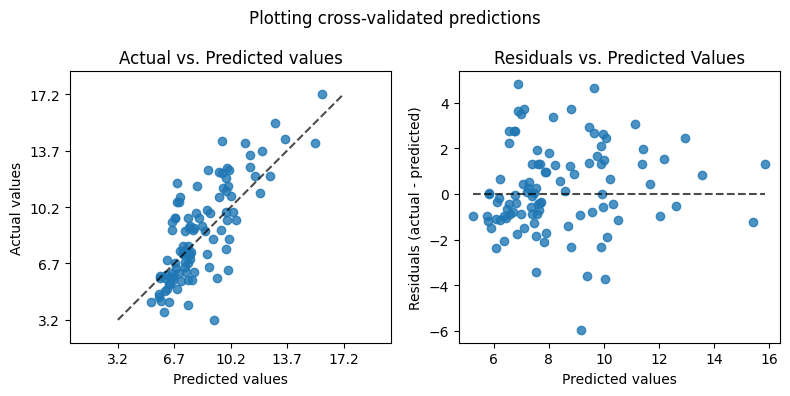

In [11]:
from sklearn.metrics import root_mean_squared_error, r2_score, PredictionErrorDisplay
import matplotlib.pyplot as plt

y_pred_log = ensemble.predict(X=X)
y_pred = np.expm1(y_pred_log)

print(f'RMSE: {root_mean_squared_error(y_true=y, y_pred=y_pred)}')
print(f'R2: {r2_score(y_true=y, y_pred=y_pred)}')

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_true=y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_true=y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show();